### Construction d'un classificateur d'arbres de décision

Ce guide décompose une implémentation personnalisée d'un classificateur d'arbre de décision en Python, en détaillant chaque méthode et paramètre.

L'implémentation inclut des fonctions essentielles telles que les calculs du chi-carré, la division des données et la construction récursive de l'arbre.

## Importation et prétraitement des données

In [50]:
import numpy as np 
import pandas as pd
import seaborn as sns

In [51]:
df = sns.load_dataset('titanic')

In [52]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [53]:
df.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [55]:
df.isna().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [56]:
df['who'].isna().sum()

np.int64(0)

In [57]:
df['who'].value_counts()

who
man      537
woman    271
child     83
Name: count, dtype: int64

## Remplir les lignes vides dans l'âge avec la moyenne de chaque classe (homme, femme ou enfant)

In [58]:
mean_child = df[df['who'] == 'child']['age'].mean()
mean_woman = df[df['who' ] == 'woman']['age'].mean()
mean_man = df[df['who' ] == 'man']['age'].mean()

df['age'] = np.where(
    (df['who'] == 'child') & df['age'].isna(), mean_child,
    np.where((df['who'] == 'man') & df['age'].isna(), mean_man,
    np.where((df['who'] == 'woman') & df['age'].isna(), mean_woman, df['age'])
    )
)

In [59]:
df['age']=df['age'].apply(lambda x: round(x))

In [60]:
df['embark_town'].value_counts()

embark_town
Southampton    644
Cherbourg      168
Queenstown      77
Name: count, dtype: int64

In [61]:
df['embark_town'] = df['embark_town'].fillna('Southampton')

In [62]:
df['embarked'].value_counts()

embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [63]:
df['embarked'] = df['embarked'].fillna('S')

In [64]:
df.isna().sum()

survived         0
pclass           0
sex              0
age              0
sibsp            0
parch            0
fare             0
embarked         0
class            0
who              0
adult_male       0
deck           688
embark_town      0
alive            0
alone            0
dtype: int64

In [65]:
df.drop(['embark_town','adult_male','who','alive','class','fare','alone'], axis=1, inplace=True)

In [66]:
df['embarked'] = df['embarked'].apply(lambda x: 1 if x == 'S' else (2 if x == 'C' else 3))
df['sex'] = df['sex'].apply(lambda x: 1 if x=='male' else 0)

In [67]:
df.head()

,survived,pclass,sex,age,sibsp,parch,embarked,deck
0,0,3,1,22,1,0,1,NaN
1,1,1,0,38,1,0,2,C
2,1,3,0,26,0,0,1,NaN
3,1,1,0,35,1,0,1,C
4,0,3,1,35,0,0,1,NaN


In [68]:
df.drop(['deck'], axis=1, inplace=True)

In [69]:
df.duplicated().sum()

np.int64(318)

In [70]:
df.drop_duplicates(inplace=True)

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 573 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   survived  573 non-null    int64
 1   pclass    573 non-null    int64
 2   sex       573 non-null    int64
 3   age       573 non-null    int64
 4   sibsp     573 non-null    int64
 5   parch     573 non-null    int64
 6   embarked  573 non-null    int64
dtypes: int64(7)
memory usage: 35.8 KB


## Analyse du taux de survie du Titanic par groupe d'âge

Ce graphique en barres affiche le taux de survie des passagers du Titanic, regroupés par groupes d'âge. D'après le graphique :

1. **Groupe d'âge 1** a le taux de survie le plus élevé, juste au-dessus de 0,5 (ou 50 %). Cela représente probablement les enfants, qui avaient plus de chances de survie en raison de la priorité donnée à l'évacuation.
2. **Groupe d'âge 2** montre un taux de survie légèrement inférieur, juste en dessous de 0,5 (près de 45 %).
3. **Groupe d'âge 3** a un taux de survie légèrement supérieur à 0,4, montrant une diminution supplémentaire.
4. **Groupe d'âge 4** a le taux de survie le plus bas, en dessous de 0,4 (environ 30 %). Cela pourrait représenter les adultes plus âgés, qui ont peut-être rencontré davantage de difficultés lors de l'évacuation.

La tendance suggère que les passagers plus jeunes avaient de meilleures chances de survie que les plus âgés, ce qui correspond aux récits historiques du processus d'évacuation du Titanic, où "les femmes et les enfants d'abord" étaient souvent privilégiés.

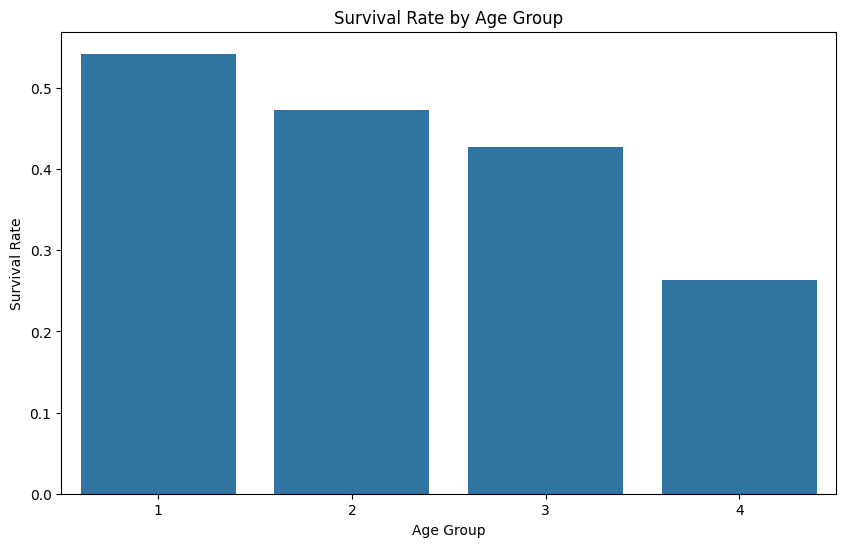

In [72]:
import matplotlib.pyplot as plt

bins = []
for i in range(1,82,20):
    bins.append(i)
bins = [0, 21,41,61,81]
labels = [1,2,3,4]
df['age_group'] = pd.cut(df['age'], bins=bins, right=False,labels=labels)

age_group_survival = df.groupby('age_group',observed=False)['survived'].mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=age_group_survival.index, y=age_group_survival.values)
plt.title('Survival Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Survival Rate')
plt.show()

### Division des données pour l'entraînement et le test (10% car nos données sont petites !)

In [73]:
df = df.drop('age', axis=1)

In [74]:
X = df.drop('survived', axis=1)
y = df['survived']

In [75]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## Construction de notre arbre

**Cette méthode privée (chi_square) calcule les valeurs du chi-carré pour chaque caractéristique du jeu de données. La caractéristique ayant la valeur du chi-carré la plus élevée est sélectionnée pour la division.**

In [76]:

def chi_square(X, y):
    chi_outputs = np.empty((X.shape[1]), dtype=float)
    chi_index = np.empty((X.shape[1]), dtype=object)
    for i in range(X.shape[1]):
        y_features = y.unique()
        x_features = X.iloc[:, i].unique()
        chi_square_value = 0
        chi_index[i] = X.columns[i]
        for j in x_features:
            count_0 = np.sum((X.iloc[:, i] == j) & (y == y_features[0]))
            count_1 = np.sum((X.iloc[:, i] == j) & (y == y_features[1]))
            total = count_0 + count_1
            e = total / 2
            chi_square_value += ((e - count_0) ** 2 / e) ** 0.5
        chi_outputs[i] = chi_square_value
    return chi_index, chi_outputs

idx, chi = chi_square(x_train, y_train)

print(pd.DataFrame(chi.reshape(1, -1), columns=idx),"\n")

max_chi_index = np.argmax(chi)
best_feature = idx[max_chi_index]
print(f"The best feature for splitting is: {best_feature}")

     pclass      sex     sibsp     parch  embarked  age_group
0  7.388063  9.83721  5.485848  5.881037  3.936639   3.429798 

The best feature for splitting is: sex


**Cette méthode (get_feature) calcule le comptage de chaque étiquette de classe (par exemple, survécu vs non survécu) pour une caractéristique donnée. Elle permet de comprendre la répartition des étiquettes de classe pour chaque valeur unique de la caractéristique.**

In [77]:

def get_feature(X,y,feature):
    y_features = y.unique()
    x_features = X[feature].unique()
    count_0 = np.empty((len(x_features)), dtype=int)
    count_1 = np.empty((len(x_features)), dtype=int)
    for i in range(len(x_features)):
        count_0[i] = np.sum((X[feature] == x_features[i]) & (y == y_features[0]))
        count_1[i] = np.sum((X[feature] == x_features[i]) & (y == y_features[1]))
    return x_features, count_0, count_1

x_features, count_0, count_1 = get_feature(x_train, y_train, best_feature)

print(f"Feature: {best_feature}")
print(f"Values: {x_features}")
print(f"Survived: {count_1}")
print(f"Did not survive: {count_0}")

Feature: sex
Values: [0 1]
Survived: [166  84]
Did not survive: [ 62 203]


**Cette méthode (split_data) divise le jeu de données en fonction d'une caractéristique et d'une valeur données, renvoyant deux sous-ensembles de données : un où la caractéristique correspond à la valeur et un autre où elle ne correspond pas.**

In [78]:
def split_data(X, y, feature, value):

    if feature not in X.columns:
        raise KeyError(f"Feature '{feature}' not found in the dataset")
    
    X_left = X[X[feature] == value]
    y_left = y[X[feature] == value]
    
    X_right = X[X[feature] != value]
    y_right = y[X[feature] != value]
    
    X_left = X_left.reset_index(drop=True)
    y_left = y_left.reset_index(drop=True)
    X_right = X_right.reset_index(drop=True)
    y_right = y_right.reset_index(drop=True)
    
    return X_left, y_left, X_right, y_right


**Ensuite, cette méthode récursive construit l'arbre de décision en sélectionnant la meilleure caractéristique pour chaque division. Si un nœud remplit certaines conditions d'arrêt (par exemple, petite taille d'échantillon), il devient un nœud terminal avec une prédiction.**

In [79]:
def build_tree(X, y, min_samples=100):
    if len(y.unique()) == 1:
        return {'prediction': y.iloc[0]}  
    
    if X.shape[1] == 0:
        return {'prediction': y.mode()[0]}  
    
    if len(y) <= min_samples:
        return {'prediction': y.mode()[0]}  
    
    chi_index, chi_outputs = chi_square(X, y)
    best_feature_index = np.argmax(chi_outputs)
    best_feature = chi_index[best_feature_index]
    
    node = {'feature': best_feature}
    
    x_features, count_0, count_1 = get_feature(X, y, best_feature)
    node['count_0'] = count_0.sum()
    node['count_1'] = count_1.sum()
    
    branches = {}
    for value in x_features:
        X_left, y_left, X_right, y_right = split_data(X, y, best_feature, value)
        
        if X_left.empty or X_right.empty:
            branches[value] = {'prediction': y.mode()[0]}
        else:
            branches[value] = {
                'left': build_tree(X_left.drop(columns=[best_feature]), y_left, min_samples),
                'right': build_tree(X_right.drop(columns=[best_feature]), y_right, min_samples)
            }
        
    node['branches'] = branches
    return node

root = build_tree(x_train, y_train)


## Évaluation du modèle

**Cette méthode traverse l'arbre de décision pour un échantillon de données unique, renvoyant une prédiction basée sur le nœud terminal atteint.**

In [81]:
def predict_single(tree, sample):
    
    if 'prediction' in tree:
        return tree['prediction']  

    feature = tree['feature']
    feature_value = sample[feature]

    if feature_value in tree['branches']:
        branch = tree['branches'][feature_value]

        if 'left' in branch:
            return predict_single(branch['left'], sample)
        elif 'right' in branch:
            return predict_single(branch['right'], sample)
    return y.mode()[0]  



def predict(tree, X):
    return X.apply(lambda row: predict_single(tree, row), axis=1)

y_pred = predict(root, x_test)
accuracy = (y_pred == y_test).mean()
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 75.86%


Après avoir entraîné l'arbre de décision sur le jeu de données du Titanic, le modèle a atteint une précision d'environ 75,86 %. Ce résultat indique que l'arbre a appris des motifs significatifs à partir des données.

### Ce graphique représente un modèle d'arbre de décision entraîné sur le jeu de données du Titanic. Chaque nœud de l'arbre correspond à un point de décision basé sur l'une des caractéristiques du jeu de données, avec des comptages des résultats de survie. Voici un aperçu des composants de l'arbre

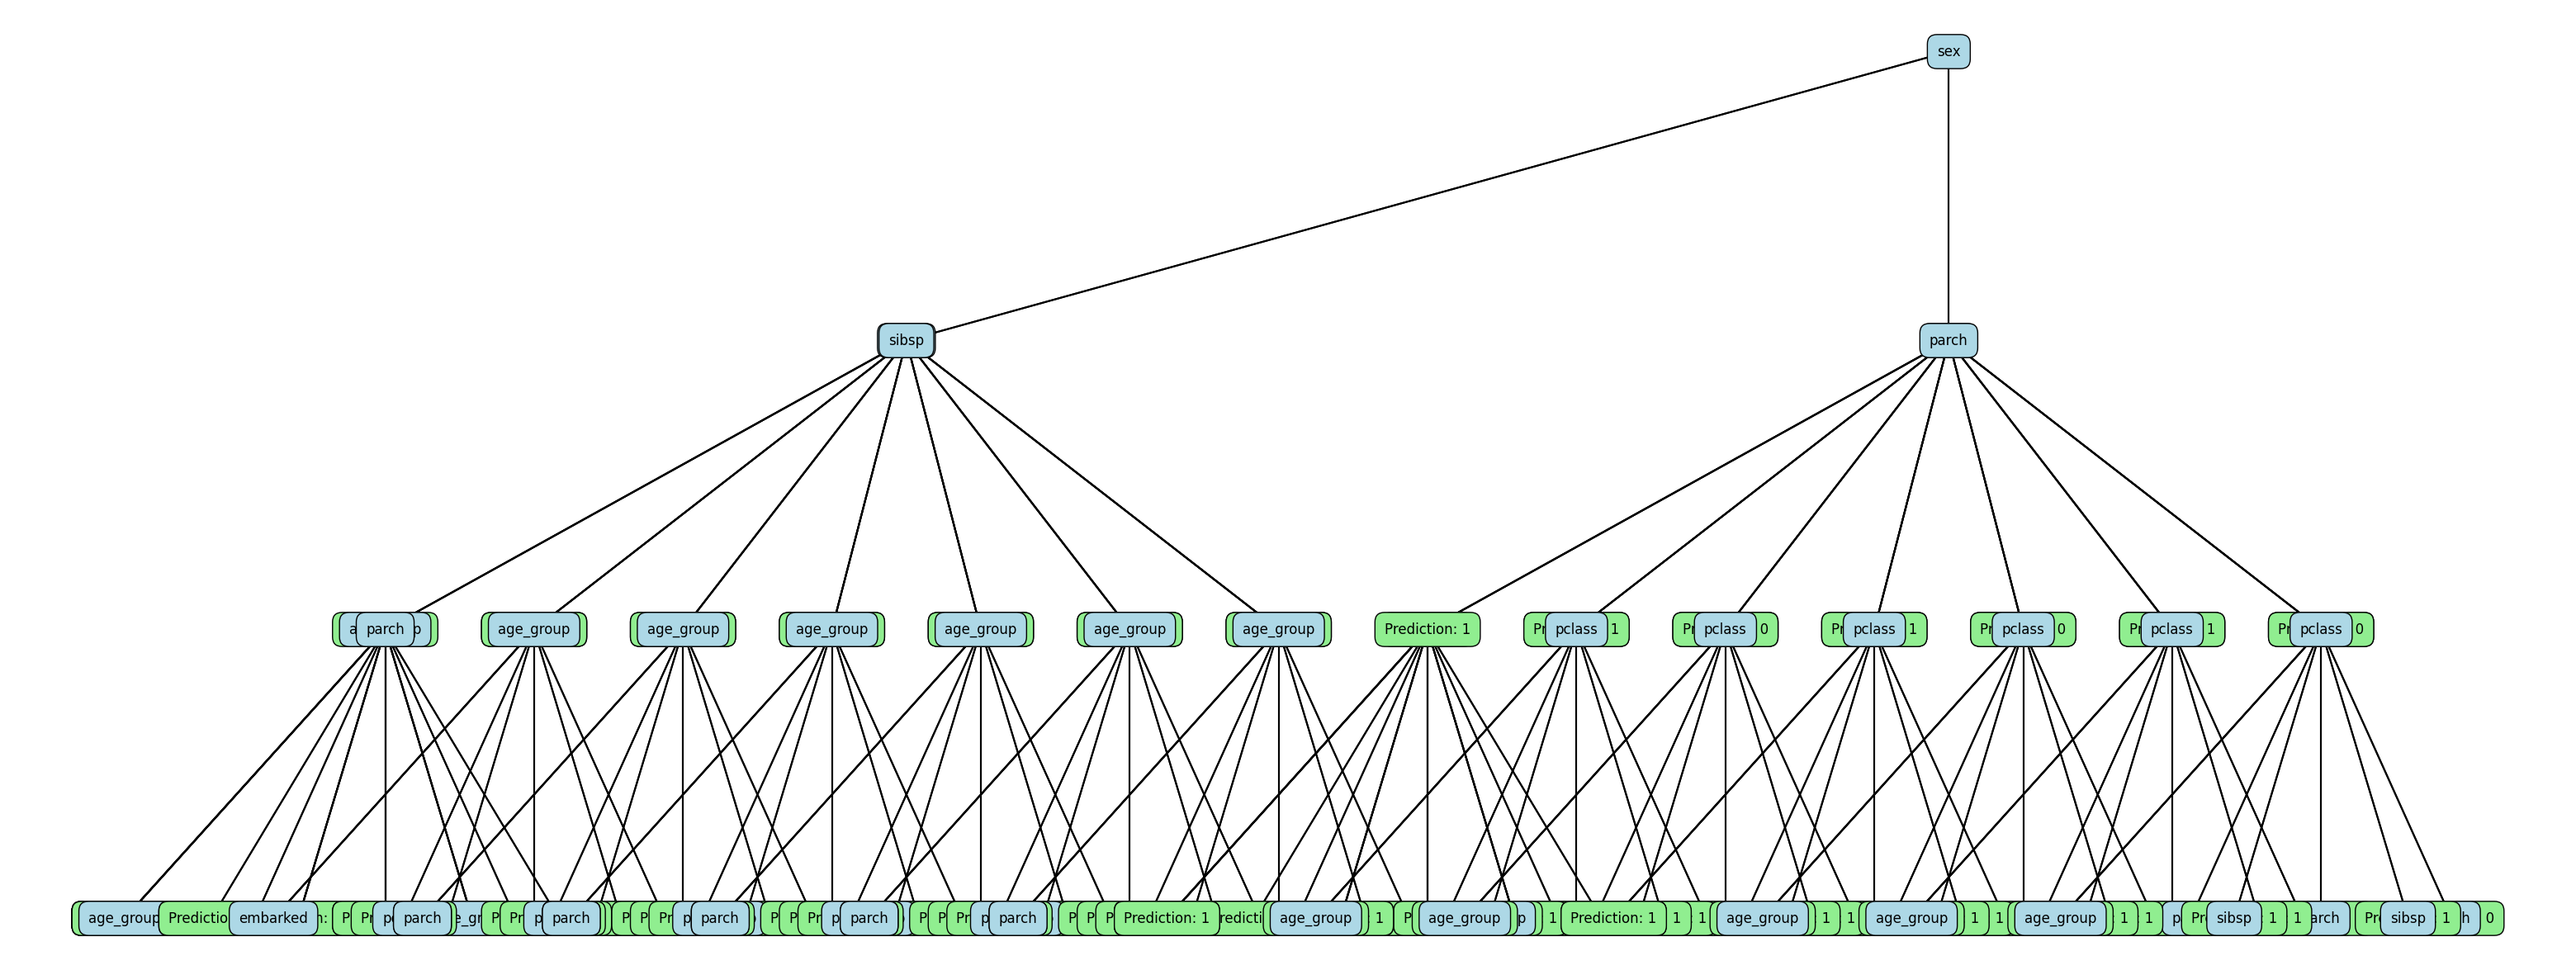

In [82]:
def plot_tree_recursive(node, parent, depth, pos, offset, ax, max_depth=3):
    
    decision_node_style = dict(boxstyle="round,pad=0.7", fc="lightblue", ec="black")
    leaf_node_style = dict(boxstyle="round,pad=0.7", fc="lightgreen", ec="black")
    
    if depth > max_depth:
        return
    
    if 'prediction' in node:
        plot_node(f"Prediction: {node['prediction']}", pos, parent, leaf_node_style, ax)
    else:

        feature_text = f"{node['feature']}"
        plot_node(feature_text, pos, parent, decision_node_style, ax)
        
        num_branches = len(node['branches'])
        branch_index = 0
        for value, branch in node['branches'].items():
            new_x = pos[0] - offset + (2 * offset / num_branches) * branch_index
            new_y = pos[1] - 2 
            branch_index += 1
            
            if 'left' in branch:
                plot_tree_recursive(branch['left'], pos, depth + 1, (new_x, new_y), offset / 2, ax, max_depth)
            if 'right' in branch:
                plot_tree_recursive(branch['right'], pos, depth + 1, (new_x, new_y), offset / 2, ax, max_depth)

def plot_tree(root, max_depth=3):
    fig, ax = plt.subplots(figsize=(40, 15)) 
    ax.axis("off")  
    plot_tree_recursive(root, parent=None, depth=0, pos=(0.5, 1), offset=0.4, ax=ax, max_depth=max_depth)
    plt.show()

plot_tree(root, max_depth=3)
